In [1]:
!pip install wordcloud
!pip install gensim
!pip install -U sentence-transformers

# Etapa 1: Modelagem de Sentenças

In [2]:
# MODEL = 'bert-base-cased'
MODEL = 'dmis-lab/biobert-base-cased-v1.1'
# MODEL = 'fagner/envoy'
# MODEL = 'biobert-iln'
# MODEL = 'bert-sts'

In [3]:
import os.path
import pandas as pd
from sentence_transformers import SentenceTransformer

DATASET = 'clicr'
DATASET_PATH = '../datasets/'+DATASET+'/titles.txt'

sentences = []
with open(DATASET_PATH) as f:
    sentences = f.readlines()

OUTPUT_PATH = 'output/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
# OUTPUT_PATH += 'TopicAttention/'
# if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += DATASET + '/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += MODEL + '/'
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH, exist_ok=True)

In [4]:
MODEL_PATH = '../../models/' + MODEL
model = SentenceTransformer(MODEL)
# model = SentenceTransformer(MODEL_PATH)

embeddings = model.encode(sentences)

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

No sentence-transformers model found with name /home/jovyan/.cache/torch/sentence_transformers/dmis-lab_biobert-base-cased-v1.1. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/jovyan/.cache/torch/sentence_transformers/dmis-lab_biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly 

In [5]:
# TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_2/' + DATASET + '/' + MODEL + '/'

# embeddings_dataframe = pd.read_csv(TSV_INPUT_PATH + 'word_embeddings.tsv', sep='\t',header=None)
# embeddings_numpy = embeddings_dataframe.to_numpy()

# embeddings = embeddings_numpy[:, :-1]

In [6]:
# sentences_dataframe = pd.read_csv(FILE, sep='\t',header=None)
# sentences = sentences_dataframe.to_numpy()

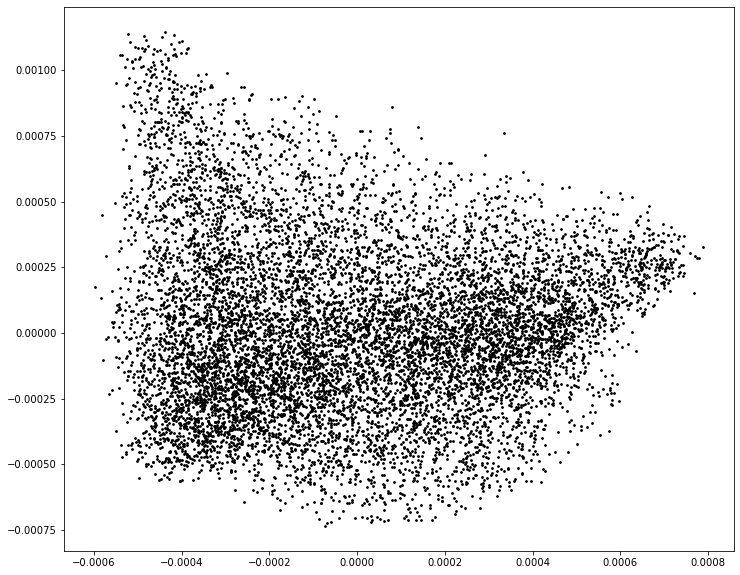

In [7]:
from matplotlib import pyplot as plt 
from sklearn import manifold

X_2d = manifold.SpectralEmbedding(n_components=2).fit_transform(embeddings)
 
x = X_2d[:,0]
y = X_2d[:,1]

plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black', s=3)
plt.savefig(OUTPUT_PATH + 'sentence-embeddings-'+str(MODEL).replace('/','').replace('.',''))

In [8]:
plt.show()

# Etapa 2: Agrupamento de Sentenças

In [17]:
# DISTANCE_THRESHOLD =  48 # 100  80 62 55 48 bert-base-cased
DISTANCE_THRESHOLD  =  52 # 90  biobert
# DISTANCE_THRESHOLD =   160 # 460 300 220 180 130envoy
# DISTANCE_THRESHOLD =   125 # 300 iln-biobert
# DISTANCE_THRESHOLD =   175  #   150 130 120 96 95.6 sts-bert


In [18]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(linkage='ward', distance_threshold=DISTANCE_THRESHOLD, n_clusters=None)
clustering_model = clustering_model.fit(embeddings)

colors = [plt.cm.nipy_spectral(label / 10.) for label in clustering_model.labels_]
n_clusters = clustering_model.n_clusters_

print('Distance Threshold: ', DISTANCE_THRESHOLD)
print('Agrupamentos resultantes',  n_clusters)

Distance Threshold:  52
Agrupamentos resultantes 7


<Figure size 432x288 with 0 Axes>

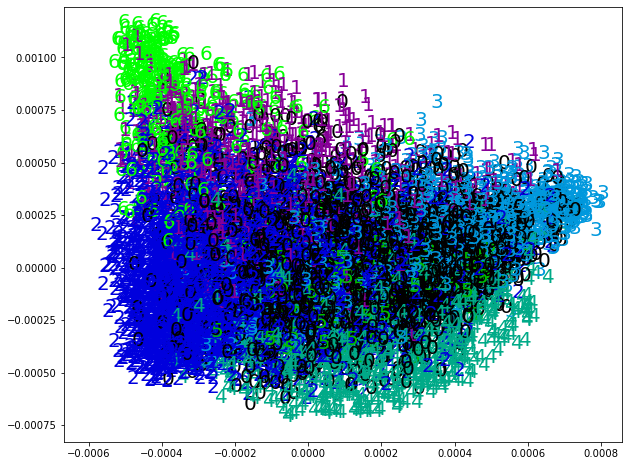

In [19]:
plt.clf()
plt.figure(figsize=(10, 8))

plt.scatter(x, y, color='w', s=1)
# plt.scatter(x, y, color=colors, s=1, cmap='hsv_r')

for i, sentence in enumerate(sentences):
    # plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color='gray', fontsize=18)
    plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=20)
    

if not os.path.exists(OUTPUT_PATH + str(n_clusters) + 'topics'): os.mkdir(OUTPUT_PATH + str(n_clusters) + 'topics')

plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-axis-on-'+str(MODEL).replace('/','').replace('.',''))

<Figure size 432x288 with 0 Axes>

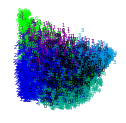

In [33]:
plt.clf()
plt.figure(figsize=(2, 2))

plt.scatter(x, y, color='w', s=1)

for i, sentence in enumerate(sentences):
    # plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color='gray', fontsize=18)
    plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=5)

plt.axis("off")
plt.show()
# plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-axis-off-'+str(MODEL).replace('/','').replace('.',''))

## Topic Hierarchy

<Figure size 432x288 with 0 Axes>

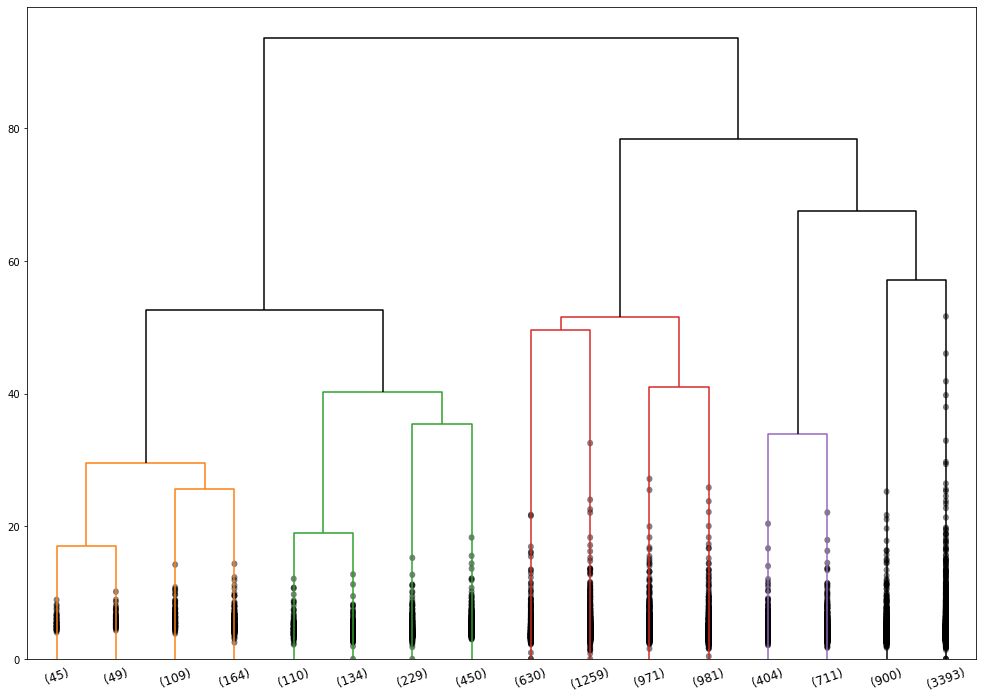

In [21]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

plt.clf()
plt.figure(figsize=(17,12))

counts = np.zeros(clustering_model.children_.shape[0])
n_samples = len(clustering_model.labels_)

for i, merge in enumerate(clustering_model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else: current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clustering_model.children_, clustering_model.distances_, counts]).astype(float)

# r = dendrogram(linkage_matrix,  count_sort='ascending')
r = dendrogram(linkage_matrix, truncate_mode='level', p=3, color_threshold=DISTANCE_THRESHOLD, count_sort='ascending', leaf_rotation=20, above_threshold_color='black', show_contracted=True)

plt.savefig(OUTPUT_PATH + 'dendrograma-'+str(MODEL).replace('/','').replace('.',''))

# Etapa 3: Extração de Tópicos

In [22]:
MIN_DF = 1
MAX_DF = 0.99

In [23]:
class Topic:
    def __init__(self, cluster):
        self.cluster = cluster
        self.sentences = []
        self.sentences_dump = ""
        self.wordcloud = WordCloud()
        self.top_terms = []
        self.top_tfidfs = []
        self.coherence = 0.0
        
    # def __str__(self):
    #     return str(self.label)

In [24]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

topics = [Topic(i) for i in range(n_clusters)]
documents_by_topic = [[] for i in range(n_clusters)]
n_cases_by_cluster = [0 for i in range(n_clusters)]

for i in range(len(sentences)):
    cluster_index = clustering_model.labels_[i]
    topics[cluster_index].sentences.append(sentences[i])
    topics[cluster_index].sentences_dump += sentences[i] + " "
    n_cases_by_cluster[cluster_index] += 1

tfidf_model = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF)
# tfidf_model = TfidfVectorizer(stop_words='english')

document_term_matrix = tfidf_model.fit_transform([topic.sentences_dump for topic in topics])

terms = tfidf_model.get_feature_names_out()
terms_by_topic = tfidf_model.inverse_transform(document_term_matrix)
tfidf_matrix = document_term_matrix.toarray()

for topic in topics:
    sorted_tfidf = np.argsort(tfidf_matrix[topic.cluster])
    top_tfidf_indexes = sorted_tfidf[:]

    top_terms, top_tfidfs = [], []
    for i in sorted_tfidf:
        top_terms.append(terms[i])
        top_tfidfs.append(tfidf_matrix[topic.cluster][i])
       
    topic.top_terms = top_terms
    topic.top_tfidfs.append(top_tfidfs)
    
    dense = document_term_matrix[topic.cluster].todense()
    lst1 = dense.tolist()
    tfidf_data_frame = pd.DataFrame(lst1, columns=terms)

    wordcloud = WordCloud(mode='RGBA', background_color='white', max_words=20, color_func=lambda *args, **kwargs: "black").generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))
    topic.wordcloud = wordcloud

<Figure size 432x288 with 0 Axes>

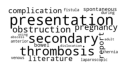

<Figure size 432x288 with 0 Axes>

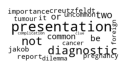

<Figure size 432x288 with 0 Axes>

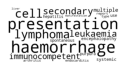

<Figure size 432x288 with 0 Axes>

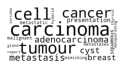

<Figure size 432x288 with 0 Axes>

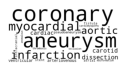

<Figure size 432x288 with 0 Axes>

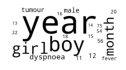

<Figure size 432x288 with 0 Axes>

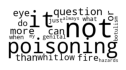

In [25]:
for topic in topics:
    plt.clf()
    # plt.figure(figsize=(5, 4))
    plt.figure(figsize=(2, 2))

    plt.imshow(topic.wordcloud)
    plt.axis("off")
    plt.show()
    plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/wordcloud'+str(topic.cluster))

# Validação

In [28]:
TOP_WORDS = 20

In [29]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

dictionary = Dictionary(terms_by_topic)
corpus = [dictionary.doc2bow(t) for t in terms_by_topic]
texts = [[dictionary[word_id] for word_id, freq in c] for c in corpus]

cm = CoherenceModel(topics=[topic.top_terms for topic in topics], texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)
# cm = CoherenceModel(topics=top_terms_by_topic, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)

total_coherence = cm.get_coherence()
coherence_per_topic = cm.get_coherence_per_topic()

for i, coherence in enumerate(coherence_per_topic):
    topics[i].coherence = coherence

print('Total Coherence: ', total_coherence)
print('Coherence by Topic: ', coherence_per_topic)    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [30]:
with open(OUTPUT_PATH + '/topic-attention-results.txt', "a") as file:
    print('Hyper-parameters: ', file=file) 
    print('Language Model: ' + MODEL + '\t Distance Threshold: '+str(DISTANCE_THRESHOLD) + '\t Resulting Topics: '+str(n_clusters) + '\t TfIdf Threshold: '+str(MAX_DF) + '\t Top Words: '+str(TOP_WORDS), file=file)   
    print("", file=file)
    for topic in topics:
        print('Topic '+str(topic.cluster), file=file)    
        print('Coherence: '+str(topic.coherence), file=file)
        print('Topic Size: '+str(len(topic.sentences)), file=file)
        print('Top Words: '+str(topic.top_terms[-10:]), file=file)    
        print('', file=file)

    print('Coerência total: '+str(total_coherence), file=file)  
    print('----------------------------------------------------------------------------', file=file)  

In [27]:
###### GRAFICO DE BARRAS (falta orientar a objetos)

# # fig, axes = plt.subplots(1, len(top_terms_by_topic), figsize=(30, 15), sharex=True)
# plt.clf()
# # axes = axes.flatten()

# # print(top_terms_by_topic[0][-1])
# for i in range(len(top_terms_by_topic)):
#     # ax = axes[i]
#     # print(top_terms_by_topic[i])
#     fig, ax = plt.subplots(figsize=(3, 9))
#     # plt.figure(figsize=(6, 4))


#     for j in range(len(top_tfidfs_by_topic[i])):
#         if top_tfidfs_by_topic[i][j] > 0:
#             # index_of_non_zero = j
#             break
        
    
#     print(j)
    
#     print(top_terms_by_topic[i][j], top_tfidfs_by_topic[i][j])

#     highlighted_labels = ['']*len(top_terms_by_topic[i])
#     for k in range(len(top_terms_by_topic[i])):
#         if k in [j, len(top_tfidfs_by_topic[i])-1]:
#             highlighted_labels[k] = top_terms_by_topic[i][k]

#             # print(highlighted_labels[0])
#     # print(highlighted_labels[j])

#     # ax.barh(highlighted_labels, top_tfidfs_by_topic[i], height=1)

#     ax.barh(top_terms_by_topic[i][j:], top_tfidfs_by_topic[i][j:], align='edge', linewidth=1)
#     # ax.set_title(f"topic-distribution{i +1}", fontdict={"fontsize": 30})
#     ax.invert_yaxis()
#     ax.set_ylabel('Termos')
#     ax.set_xlabel('TF-IDF')

#     ax.tick_params(axis="both", which="major")
#     # tick_label
#     #                , labelsize=1)
#     for j in "top right left".split():
#         ax.spines[j].set_visible(True)
#     fig.suptitle('Tópicos', fontsize=30)
    
#     plt.savefig(OUTPUT_PATH + '(copy)topic-distribution'+str(i+1))
#     plt.show()

# ---------------------------------------------------------------------

### Álgebra sobre espaços de sentenças e de palavras

In [31]:
val = np.inner(embeddings[0],embeddings[1])

In [ ]:
# MODEL = 'biobert-base'
# MODEL = 'bert-base-cased'
WORD_MODEL = 'ACD'

WORD_EMBEDDINGS_TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_1/' + WORD_MODEL + '/'

word_embeddings_dataframe = pd.read_csv(WORD_EMBEDDINGS_TSV_INPUT_PATH + 'word_embeddings.tsv', sep='\t',header=None)
word_embeddings_numpy = word_embeddings_dataframe.to_numpy()
word_embeddings = word_embeddings_numpy[:, :-1]

#### Buscando as palavras mais próximas de uma certa sentença

In [ ]:
WORD_EMBEDDINGS_TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_1/' + WORD_MODEL + '/labels.tsv'

terms = []
with open(WORD_EMBEDDINGS_TSV_INPUT_PATH) as f:
    terms = f.readlines()

In [ ]:
val = np.inner(embeddings[0],word_embeddings[1])
val

In [ ]:
from numpy import argsort

dists = [''] * len(word_embeddings)
dist_indexes = [''] * len(dists)

for i, embedding in enumerate(word_embeddings):
    dist = np.inner(embeddings[1],embedding)
    dists[i] = dist
    
sorted_dists = sorted(dists)
args = argsort(dists)
        
with open(OUTPUT_PATH + '/mainterms.txt', "a") as file:
    print('Word: '+WORD_MODEL, file=file)  
    print('Sentence: ' + sentences[1], file=file)
    for a in args:
        if not terms[a].startswith('##'):
            print(terms[a], file=file)   
            i = i+1
            if i>100:
                break;

    print('----------------------------------------------------------------------------', file=file)  

In [ ]:
sorted_dists[:10]

In [ ]:
terms[17730]